In [20]:
import pandas
import os
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from glob import glob
from scipy import stats
from nilearn import datasets, image, input_data, plotting


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
git_dir = '/home/users/jvogel/git/Hippocampus_AP_Axis/'

import sys
sys.path.insert(0,git_dir)
import HAP_Utils as hap

# Get hippocampus samples

In [4]:
wdir = os.path.join(git_dir, 'Data')
aba_dir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'

df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv(os.path.join(aba_dir,'normalized_microarray_donor9861/Probes.csv'))

# Run main analysis pipeline to get variables

In [5]:
pcalr_out_NEW = hap.PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=False,
                           test_gene_num = [100],
                               sanity_check_style = 'separate')

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.6758859774822009
running final model
final model fit r2 =  0.8768105093258057
running sanity_check


# HAGGIS across the brain
* Note: This next section requires you to run the code in NB1

In [6]:
# GET GENE EXPRESSION FOR HIPPOCAMPAL SAMPLES 
# loading this df takes awhile and may not work on computers without lots of memory 
# its about 60k x 4k
shtz = sorted(glob(os.path.join(aba_dir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
ncols = ['%s_%s'%(gdf.loc[x,'donor'],bigdf.columns[x]) for x in range(gdf.shape[0])]
bigdf.columns = ncols

#### Get HAGGIS for all tissue sample across the brain

In [7]:
gcx_SPCR = hap.get_gene_vector(bigdf, gene_vec=pcalr_out_NEW['betas'])

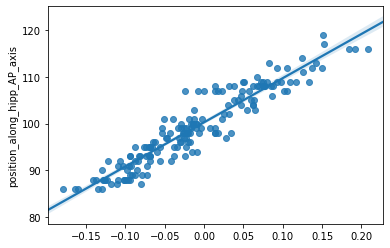

(0.942478013284813, 7.277902789017345e-82)


In [11]:
# Sanity check
rs = []
for i,samp in enumerate(xp.columns):
    svec = xp[samp]
    refvec = pcalr_out_NEW['betas']
    r,p = stats.pearsonr(svec,refvec)
    rs.append(r)
plt.close()
sns.regplot(np.array(rs),df.position_along_hipp_AP_axis)
plt.show()
print(stats.pearsonr(np.array(rs),df.position_along_hipp_AP_axis))

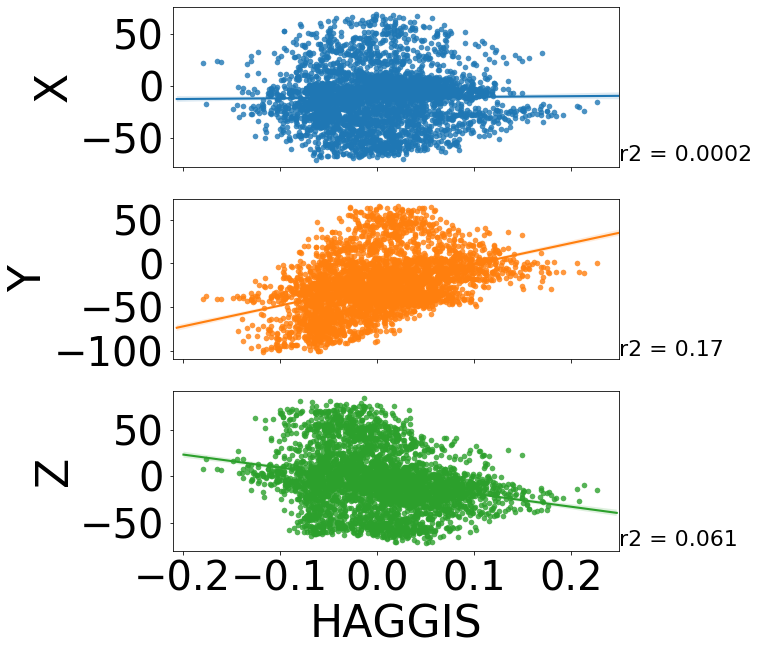

In [12]:
sns.set_context('paper',font_scale=5)
gcx_SPCR = gdf.AP_axis_gxp_signature_similarity_SPCR.values
plt.close()
fig,(ax1, ax2, ax3) = plt.subplots(3, figsize=(8,10))
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_x, ax=ax1)
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_y, ax=ax2)
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_z, ax=ax3)
plt.xlabel('HAGGIS')
#ax1.set(ylabel='MNI X\nCoordinate')
ax1.set(ylabel='X')
ax1.set(xticks=[-0.2,-0.1,0,0.1,0.2])
ax1.set(xlim=(-0.21, 0.25))
ax1.set(xticklabels=['','','','',''])
#ax2.set(ylabel='MNI Y\nCoordinate')
ax2.set(ylabel='Y')
ax2.set(xticks=[-0.2,-0.1,0,0.1,0.2])
ax2.set(xlim=(-0.21, 0.25))
ax2.set(yticks=[-100,-50,0,50])
ax2.set(xticklabels=['','','','',''])
#ax3.set(ylabel='MNI Z\nCoordinate')
ax3.set(ylabel='Z')
ax3.set(xticks=[-0.2,-0.1,0,0.1,0.2])
ax3.set(xlim=(-0.21, 0.25))

xr = stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_x)[0]**2
yr = stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_y)[0]**2
zr = stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_z)[0]**2
plt.text(0.25, 340,'r2 = %s'%float('%.2g'%xr), fontsize=22)
plt.text(0.25, 130,'r2 = %s'%float('%.2g'%yr), fontsize=22)
plt.text(0.25, -75,'r2 = %s'%float('%.2g'%zr), fontsize=22)
#plt.savefig(os.path.join(fig_dir,'XYZ_plots_revised.pdf',
#           bbox_inches='tight')
plt.show()


In [8]:
gdf.loc[:,'AP_axis_gxp_signature_similarity_SPCR'] = gcx_SPCR
gdf.to_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'),index=False)

## Plot the HAGGIS across the whole brain

In [9]:
mni = os.path.join(wdir,'MNI152_T1_1mm_brain.nii.gz')
vec = gdf.AP_axis_gxp_signature_similarity_SPCR.values
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'test'
gcx_img = hap.make_expression_image(vec, input_coords, mni, wdir, nm, 3, return_img=True)

In [13]:
plotting.view_img(gcx_img)

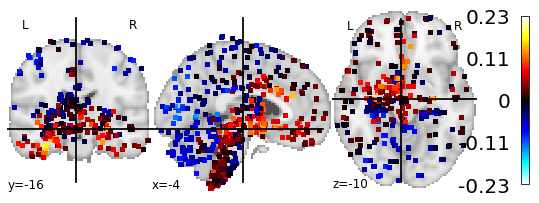

In [56]:
plt.close()
plotting.plot_stat_map(gcx_img,cut_coords=[-4,-16,-10])
plt.show()

## Revision: Let's investigate some spatial trends related to HAGGIS

#### Anterior-posterior split at the brainstem

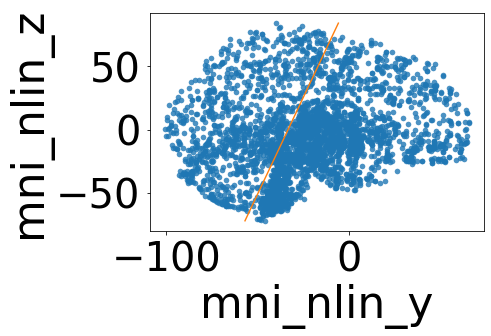

In [14]:
plt.close()
sns.regplot(gdf.mni_nlin_y, gdf.mni_nlin_z, fit_reg=False)
g = plt.plot([-57,-6],[min(gdf.mni_nlin_z.values), max(gdf.mni_nlin_z.values)])
plt.show()

Find samples on either sides of that diagonal line, which is supposed to hug the dorsal axis of the brainstem

In [16]:
y1 = min(gdf.mni_nlin_z.values)
y2 = max(gdf.mni_nlin_z.values)
x1 = -54
x2 = 0

# Validate
m = (y2 - y1) / (x2 - x1)
b = y1 - (m*x1)
qy = (m*x2) + b
np.isclose(qy,y2)

True

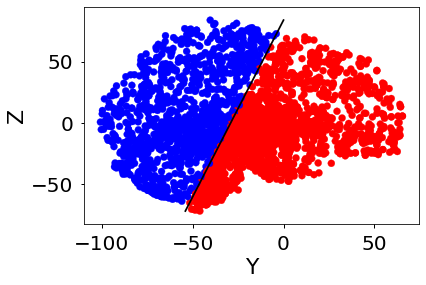

In [17]:
sns.set_context('notebook',font_scale=2)

a = np.array([x1,y1])
b = np.array([x2,y2])
isabove = lambda p, a,b: np.cross(p-a, b-a) < 0

coords = np.array(list((zip(gdf.mni_nlin_y.values, gdf.mni_nlin_z.values))))
plt.close()

plt.plot([-54,0],[min(gdf.mni_nlin_z.values), max(gdf.mni_nlin_z.values)], color='k')
plt.scatter(coords[:,0],coords[:,1], c=isabove(coords,a,b), cmap="bwr_r", vmin=0, vmax=1)
plt.xlabel('Y')
plt.ylabel('Z')
#plt.savefig(os.path.join(fig_dir,'NCRevisions/R2_AP_Arbit.png'),
#           bbox_inches='tight')
plt.show()


In [21]:

colors = [get_cmap('RdBu')(30), get_cmap('RdBu')(200)]

gdf.loc[gdf.index[isabove(coords,a,b)], 'AntPost'] = 'Posterior'
gdf.loc[gdf.index[~isabove(coords,a,b)], 'AntPost'] = 'Anterior'

How does HAGGIS do in discriminating A/P samples by this arbitrary criterion?

In [22]:
for i,row in gdf.iterrows():
    if row['AntPost'] == 'Anterior':
        if row['AP_axis_gxp_signature_similarity_SPCR'] > 0:
            gdf.loc[i,'acc_class'] = 1
        else:
            gdf.loc[i,'acc_class'] = 0
    elif row['AntPost'] == 'Posterior':
        if row['AP_axis_gxp_signature_similarity_SPCR'] < 0:
            gdf.loc[i,'acc_class'] = 1
        else:
            gdf.loc[i,'acc_class'] = 0

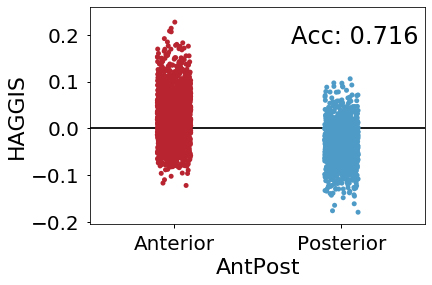

In [25]:
plt.close()
sns.stripplot(x='AntPost', y='AP_axis_gxp_signature_similarity_SPCR', data=gdf,jitter=True,
             palette=colors)
plt.ylabel('HAGGIS')
plt.plot([-.5,1.5],[0,0], color = 'k')
plt.text(.70,0.18,'Acc: %s'%round(gdf.acc_class.mean(),3))
# plt.savefig(os.path.join(fig_dir,'R2_AP_Arbit_Test.png'),
#            bbox_inches='tight')
plt.show()

Quick look at the split between Brain Slabs

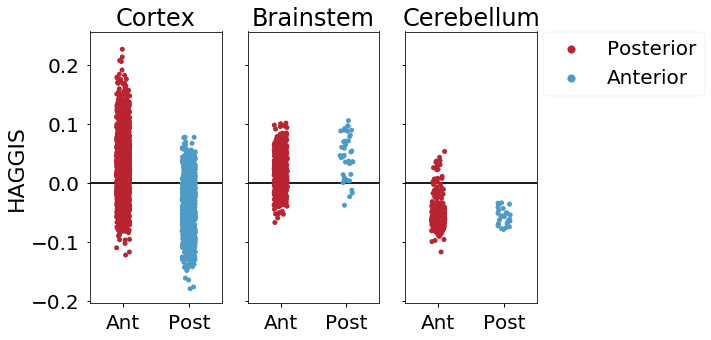

In [28]:


plt.close()
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3, sharey=True, figsize=(8,5))
sns.stripplot(x='AntPost', y='AP_axis_gxp_signature_similarity_SPCR', 
              data=gdf[gdf.slab_type=='CX'], palette=colors, jitter=True,
              ax=ax1)
ax1.set_ylabel('HAGGIS')
ax1.set_title('Cortex')

sns.stripplot(x='AntPost', y='AP_axis_gxp_signature_similarity_SPCR', 
              data=gdf[gdf.slab_type=='BS'],palette=colors, jitter=True,
              ax=ax2)
ax2.set_ylabel('')
ax2.set_title('Brainstem')

sns.stripplot(x='AntPost', y='AP_axis_gxp_signature_similarity_SPCR', 
              data=gdf[gdf.slab_type=='CB'], palette=colors, jitter=True,
              ax=ax3, hue='AntPost')
ax3.set_ylabel('')
ax3.set_title('Cerebellum')

for ax in [ax1,ax2,ax3]:
    ax.plot([-.5,1.5],[0,0], color = 'k')
    ax.set_xlabel('')
    ax.set_xticklabels(['Ant','Post'])

ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig(os.path.join('R2_AP_Arbit_slab.png'),
#           bbox_inches='tight')
plt.show()

#### AT/PM System

In [29]:
# Gather AT samples

amygs = ['basolateral nucleus, left',
'basolateral nucleus, right',
'lateral nucleus, left',
'lateral nucleus, right',
'central nucleus, left',
'central nucleus, right',
'basomedial nucleus, left',
'basomedial nucleus, right',
'amygdalohippocampal transition zone, left',
'amygdalohippocampal transition zone, right']
print('amygdala',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in amygs]))
tpoles = [x for x in gdf.structure_name.unique() if 'temporal pole' in x and 'inferior' in x]
print('tpole',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in tpoles]))
ofronts = [x for x in gdf.structure_name.unique() if 'orbital' in x]
print('ofront',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in ofronts]))
AT_system = amygs + tpoles + ofronts
AT_samps = [i for i in gdf.index if gdf.loc[i,'structure_name'] in AT_system]
print('whole AT system',len(AT_samps))

amygdala 56
tpole 11
ofront 84
whole AT system 151


In [30]:
# Gather PM samples

mbs = [x for x in gdf.structure_name.unique() if 'mammillary' in x and 'hypothal' not in x]
print('mam bod',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in mbs]))
athal = ['anterior group of nuclei, left','anterior group of nuclei, right']
print('a thalamus',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in athal]))
prec = [x for x in gdf.structure_name.unique() if 'precuneus' in x]
print('precun',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in prec]))
angg = [x for x in gdf.structure_name.unique() if 'angular gyrus' in x]
print('ang gyr',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in angg]))
pccs = [x for x in gdf.structure_name.unique() if 'cingulate' in x and 'parietal' in x]
print('pcc',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in pccs]))
rscs = [x for x in gdf.structure_name.unique() if 'cingulate' in x and 'retrosplenial' in x]
print('rsc',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in rscs]))
PM_system = mbs + athal + prec + angg + pccs + rscs
PM_samps = [i for i in gdf.index if gdf.loc[i,'structure_name'] in PM_system]
print('whole PM system',len(PM_samps))

mam bod 20
a thalamus 28
precun 52
ang gyr 47
pcc 42
rsc 15
whole PM system 204


Add PHG and PRC using mask from Ritchie et al.
NOTE: For the next section, we downloaded PRC/PHG masks from this dataset: 

https://neurovault.org/collections/3731/

In [32]:
## Input /path/to/masks/downloaded/from/above/link
Ritchey_dir = '/home/users/jvogel/ace_mount/ace_home/transfer/'

In [33]:
phg = ni.load(os.path.join(Ritchey_dir,'FINAL_PHC_mask.nii.gz')).get_data()
prc = ni.load(os.path.join(Ritchey_dir,'FINAL_PRC_mask.nii.gz')).get_data()
phg_samps = []
prc_samps = []
for i in gdf.index:
    coords = hap.convert_coords(gdf.loc[i,['mni_nlin_x','mni_nlin_y','mni_nlin_z']].tolist(),'xyz')
    xs,ys,zs = hap.make_sphere(coords,3)
    for x in range(len(xs)):
        ph_hits = []
        pr_hits = []
        if phg[xs[x],ys[x],zs[x]] == 1:
            ph_hits.append(x)
        elif prc[xs[x],ys[x],zs[x]] == 1:
            pr_hits.append(x)
    if len(ph_hits) > len(pr_hits):
        print('parahipp')
        phg_samps.append(i)
    elif len(ph_hits) < len(pr_hits):
        print('PERIRHINAL')
        prc_samps.append(i)

PERIRHINAL
parahipp
PERIRHINAL
PERIRHINAL
PERIRHINAL
PERIRHINAL
PERIRHINAL
PERIRHINAL
PERIRHINAL
parahipp
parahipp
parahipp
PERIRHINAL
PERIRHINAL
parahipp
PERIRHINAL
PERIRHINAL
PERIRHINAL


#### And once again, let's see how HAGGIS classifies these samples

In [34]:
gdf.loc[AT_samps,'AT1_PM0'] = 'AT'
gdf.loc[PM_samps,'AT1_PM0'] = 'PM'
gdf.loc[prc_samps,'AT1_PM0'] = 'AT'
gdf.loc[phg_samps,'AT1_PM0'] = 'PM'

In [35]:
gdf.loc[:,'acc_class'] = [np.nan for x in range(len(gdf))]

for i,row in gdf.iterrows():
    if row['AT1_PM0'] == 'AT':
        if row['AP_axis_gxp_signature_similarity_SPCR'] > 0:
            gdf.loc[i,'acc_class'] = 1
        else:
            gdf.loc[i,'acc_class'] = 0
    elif row['AT1_PM0'] == 'PM':
        if row['AP_axis_gxp_signature_similarity_SPCR'] < 0:
            gdf.loc[i,'acc_class'] = 1
        else:
            gdf.loc[i,'acc_class'] = 0

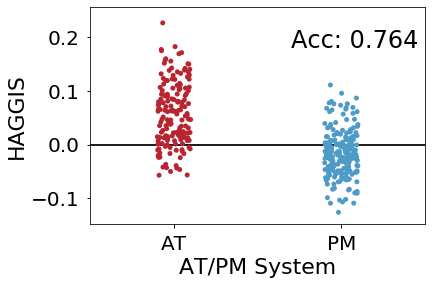

In [38]:
from matplotlib.cm import get_cmap

colors = [get_cmap('RdBu')(30), get_cmap('RdBu')(200)]
plt.close()
sns.stripplot(x='AT1_PM0', y='AP_axis_gxp_signature_similarity_SPCR', data=gdf, 
              palette=colors, jitter=True)
plt.plot([-.5,1.5],[0,0], color = 'k')
plt.ylabel('HAGGIS')
plt.xlabel('AT/PM System')
#plt.xticks('PM','AT')
plt.text(.70,0.18,'Acc: %s'%round(gdf.acc_class.mean(),3))
#plt.savefig(os.path.join(fig_dir,'/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NCRevisions/R2_ATPM_test.pdf'),
#           bbox_inches='tight')
plt.show()

#### Neural tube

In [47]:
gdfBD = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv'),
                     index_col=0)
gdfBD.loc[:,'AP_axis_gxp_signature_similarity_SPCR'] = gcx_SPCR


In [48]:
alar_medulla = ['spinal trigeminal nucleus, right', 'spinal trigeminal nucleus, left',
               'cochlear nuclei, left','cochlear nuclei, right',
               'vestibular nuclei, left','vestibular nuclei, right',
               'inferior olivary complex, left','inferior olivary complex, right',
                'gracile nucleus, left','gracile nucleus, right',
               'cuneate nucleus, left','cuneate nucleus, right',
               'superior olivary complex, left','superior olivary complex, right',]

basal_medulla = ['hypoglossal nucleus, left','hypoglossal nucleus, right',
                'lateral medullary reticular group, left','lateral medullary reticular group, right',
                'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right', 
                'arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                'central medullary reticular group, left','central medullary reticular group, right',
                'raphe nuclei of medulla',
                'gigantocellular group, left','gigantocellular group, right', ]


divs = [alar_medulla, basal_medulla]
names = ['Alar_Medulla','Basal_Medulla']
med_division = dict(zip(names,divs))

for name, div in med_division.items():
    gdfBD.loc[gdfBD[gdfBD.structure_name.isin(div)].index,'brain_divison'] = name

In [49]:
dorsal_plate = ['Cerebellum', 'Thalamus', 'Tectum', 'Alar_Medulla']
ventral_plate = ['Hypothalamus','Pons','Tegmentum','Basal_Medulla']

gdfBD.loc[gdfBD[gdfBD.brain_divison.isin(dorsal_plate)].index,'Neural_Plate'] = 'Dorsal'
gdfBD.loc[gdfBD[gdfBD.brain_divison.isin(ventral_plate)].index,'Neural_Plate'] = 'Ventral'


And classification once more

In [50]:
gdf.loc[:,'acc_class'] = [np.nan for x in range(len(gdf))]

for i,row in gdfBD.iterrows():
    if row['Neural_Plate'] == 'Ventral':
        if row['AP_axis_gxp_signature_similarity_SPCR'] > 0:
            gdf.loc[i,'acc_class'] = 1
        else:
            gdf.loc[i,'acc_class'] = 0
    elif row['Neural_Plate'] == 'Dorsal':
        if row['AP_axis_gxp_signature_similarity_SPCR'] < 0:
            gdf.loc[i,'acc_class'] = 1
        else:
            gdf.loc[i,'acc_class'] = 0

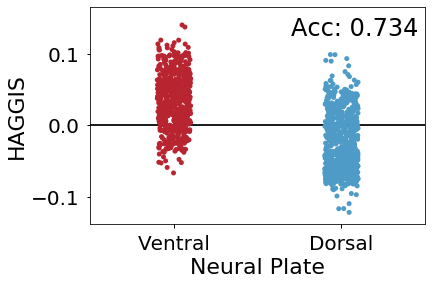

In [53]:
gdfBD.loc[:,'HAGGIS'] = gdf.AP_axis_gxp_signature_similarity_SPCR.values
plt.close()
sns.stripplot(x='Neural_Plate', y='HAGGIS', data=gdfBD, jitter=True,
              order=['Ventral','Dorsal'],palette=colors)
plt.text(.70,0.125,'Acc: %s'%round(gdf.acc_class.mean(),3))
plt.xlabel('Neural Plate')
plt.plot([-.5,1.5],[0,0], color = 'k')
#plt.savefig(os.path.join(fig_dir,'R2_NP_test.pdf',
#           bbox_inches='tight')
plt.show()